In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import matplotlib.gridspec as gs

In [2]:
from utility_fn import train_test_split , model_score
from normalize import log_norm 
#from utility_fn import trial_krn

In [3]:
en = np.linspace(0.3, 7.0 , 128)
data = np.loadtxt('data/data_spectrum.csv')
params = np.loadtxt('data/params_spectrum.csv')
print(data.shape)
print(params.shape)
data = log_norm(data)
data_noisy = data + 0.7*np.random.normal(size = data.shape)

(10000, 128)
(10000, 2)


In [4]:
(x_train,y_train) , (x_test,y_test) = train_test_split(data , params , 0.2)
x_train_noisy = x_train+0.4*np.random.normal(size=x_train.shape)
x_test_noisy = x_test+0.4*np.random.normal(size=x_test.shape)

In [5]:
enc_inputs = keras.Input(shape=(128 , ))
x = layers.Dense(64 , activation='relu')(enc_inputs)
x = layers.Dense(64, activation='relu')(x)
enc_outputs = layers.Dense(256, activation='relu')(x)

x = layers.Dense(64 , activation='relu')(enc_outputs)
x =  layers.Dense(64 , activation='relu')(x)
x = layers.Dense(128)(x)
dec_outputs = layers.LeakyReLU(alpha = 0.8)(x)
encoder = keras.Model(inputs=enc_inputs , outputs=enc_outputs , name = 'encoder')
#encoder.summary()
den_ae = keras.Model(inputs=enc_inputs , outputs=dec_outputs , name = 'autoencoder')
den_ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               

In [6]:
den_ae.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [7]:
den_ae.fit(x_train_noisy , x_train , validation_split=0.3 , epochs = 15)

Epoch 1/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0043
Epoch 2/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 5/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/15
175/175 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 8/15
175/175 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/15
175/175 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 10/15
175/175 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0025

In [8]:

def plot_recon(recon , actual):
    error = actual-recon
    fig = plt.figure(figsize=(8,6) )
    spec = gs.GridSpec(nrows=2,ncols=1, figure=fig ,  height_ratios=[2,1] , hspace=0)
    acc = fig.add_subplot(spec[0,0])
    plt.grid(True)
    acc.plot(en , recon)
    acc.plot(en , actual)
    acc.legend(['Reconstructed' , 'Actual data'])
    acc.set_ylabel('Normalized log Flux')
    loss = fig.add_subplot(spec[1,0], sharex = acc)
    loss.plot(en , error)
    loss.set_xlabel('Energy (keV)')
    loss.set_ylabel('Recon Error')
    plt.grid(True)
    return fig
    #plt.show()


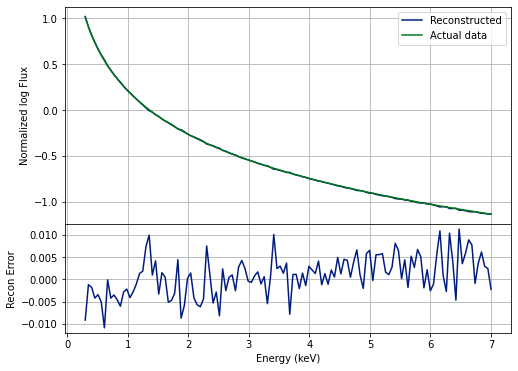

<Figure size 432x288 with 0 Axes>

In [25]:
x_recon = den_ae.predict(x_test[10:11])[0]
fig = plot_recon(x_recon , x_test[10:11][0])
plt.savefig('plots/reconstruction_no_gap.png')
plt.show()

## Quantitative Model Score

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
def recon_score(recon_model , bad_data , good_data):
    '''
    returns reconstruction error for a given model
    '''
    recon_data = recon_model.predict(bad_data)
    recon_error = mean_squared_error(good_data , recon_data)
    return recon_error
def pred_error(reg_model , data , params):
    '''
    returns parameter prediction error 
    for the given data set
    '''
    y_pred = reg_model.predict(data)
    mse = mean_squared_error(params , y_pred)
    return mse 

### simulating missing data
remove points from two data bands and then 
try reconstruction

In [12]:
def simulate_missing_data(data):
    data_missing = []
    data_noise_filled = []
    for x in data:
        temp = np.copy(x)
        temp[20:40] = np.zeros(20)
        temp[80:100] = np.zeros(20)
        data_missing.append(temp)
        temp_g = np.copy(x)
        temp_g[20:40] = 0.4*np.random.normal(0.0, 0.5 , 20)
        temp_g[80:100] = 0.4*np.random.normal(0.0, 0.5 , 20)
        data_noise_filled.append(temp_g)
    data_missing = np.asarray(data_missing)
    data_noise_filled = np.asarray(data_noise_filled)
    return data_missing , data_noise_filled


In [13]:
reg_model = keras.models.load_model('fc_model')
reg_model.summary()

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_141 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_142 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_143 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_144 (Dense)            (None, 2)                 66        
Total params: 14,562
Trainable params: 14,562
Non-trainable params: 0
_________________________________________________________________


In [14]:
x_train_gap , x_train_filled = simulate_missing_data(x_train)
x_test_gap , x_test_filled = simulate_missing_data(x_test)

#### Reconstruction score on missing data

In [15]:
test_recon_err = recon_score(den_ae , x_test_gap , x_test)
train_recon_error = recon_score(den_ae , x_train_gap , x_train)

print('reconstruction error on test data: ', test_recon_err)
print('reconstruction error on train data:' , train_recon_error)

reconstruction error on test data:  0.021429469703637013
reconstruction error on train data: 0.02139645197147263


In [16]:
test_recon_err = recon_score(den_ae , x_test_filled , x_test)
train_recon_error = recon_score(den_ae , x_train_filled , x_train)

print('reconstruction error on test data: ', test_recon_err)
print('reconstruction error on train data:' , train_recon_error)

reconstruction error on test data:  0.021569735664406304
reconstruction error on train data: 0.021585159957891766


### Checking Regression Model performence

In [17]:
print(pred_error(reg_model , x_train , y_train))
print(pred_error(reg_model , x_test , y_test))
print(pred_error(reg_model , x_train_gap , y_train))
print(pred_error(reg_model , x_test_gap , y_test))
print(pred_error(reg_model , x_train_filled , y_train))
print(pred_error(reg_model , x_test_filled , y_test))

0.0002375775524785238
0.00022291092492900165
3.231558088309905
3.253552584043526
3.438324709447164
3.5242122707212857


## Reconstruction of Missing data

In [18]:
def plot_all(data , legend):
    fig = plt.figure(figsize=(8,6))
    for d in data:
        plt.plot(en , d)
        #print('inside')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Normalized log(flux)')
    plt.grid(1)
    plt.legend(legend) 
    return fig
    #plt.show()   


Parameter reg error:0.3500


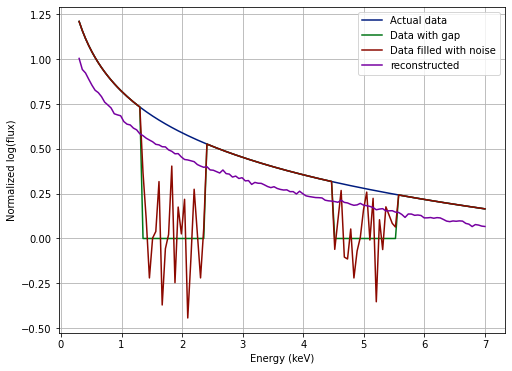

<Figure size 432x288 with 0 Axes>

In [21]:
x_train_recon = den_ae.predict(x_train_filled)
prediction_loss = pred_error(reg_model , x_train_recon , y_train)
print('Parameter reg error:{:.4f}'.format(prediction_loss))
data_to_plot = (x_train[0] ,  x_train_gap[0] , x_train_filled[0] , x_train_recon[0])
legend = ['Actual data' , 'Data with gap' , 'Data filled with noise' , 'reconstructed']
fig  = plot_all(data_to_plot, legend)
plt.savefig('plots/reconstruction_no_loop.png')
plt.show()

____________________________________________________
Parameter regression error:0.3500


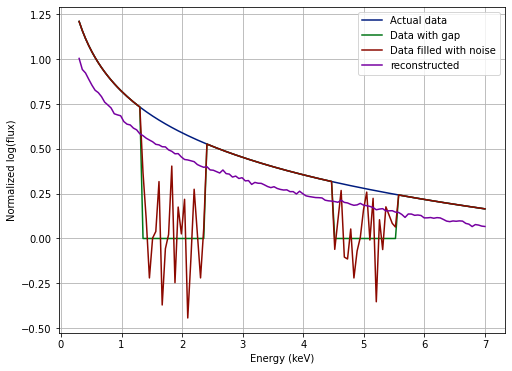

____________________________________________________
Parameter regression error:0.1222


<Figure size 432x288 with 0 Axes>

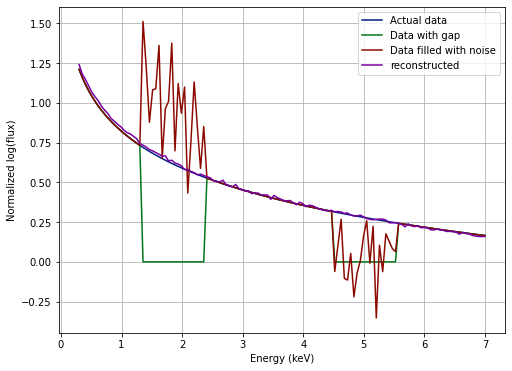

<Figure size 432x288 with 0 Axes>

____________________________________________________
Parameter regression error:0.6375


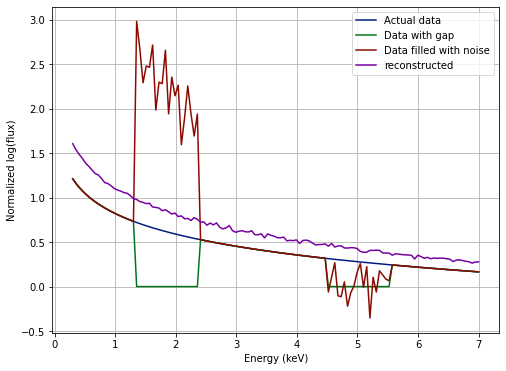

<Figure size 432x288 with 0 Axes>

In [24]:
def filling_algo(n , data_filled):
    x_train_filled = np.copy(data_filled)
    x_train_recon = den_ae.predict(x_train_filled)
    pred_loss = pred_error(reg_model , x_train_recon , y_train)
    print('____________________________________________________')
    print("Parameter regression error:{:.4f}".format(pred_loss) )
    data_to_plot = (x_train[0] ,  x_train_gap[0] , x_train_filled[0] , x_train_recon[0])
    legend = ['Actual data' , 'Data with gap' , 'Data filled with noise' , 'reconstructed']
    fig = plot_all(data_to_plot, legend)
    plt.savefig('reconstruction_0_loop.png')
    for i in range(1,n):
        for x , x_r in zip(x_train_filled , x_train_recon):
            x[20:40] = x[20:40]+x_r[20:40]
            x[20:40] = x[20:40]+x_r[20:40]
        x_train_recon = den_ae.predict(x_train_filled)
        pred_loss = pred_error(reg_model , x_train_recon , y_train)
        print('____________________________________________________')
        print("Parameter regression error:{:.4f}".format(pred_loss) )
        data_to_plot = (x_train[0] ,  x_train_gap[0] , x_train_filled[0] , x_train_recon[0])
        legend = ['Actual data' , 'Data with gap' , 'Data filled with noise' , 'reconstructed']
        fig = plot_all(data_to_plot, legend)
        plt.savefig('plots/reconst_plot_loop'+str(i)+'.png')
        plt.show()

filling_algo(3 , x_train_filled)